In [24]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
IMAGE_SIZE = (220, 220)
LABEL_COLUMNS = [
    'Early Blight', 'Healthy', 'Late Blight', 'Leaf Miner', 'Leaf Mold',
    'Mosaic Virus', 'Septoria', 'Spider Mites', 'Yellow Leaf Curl Virus'
]

In [3]:
def clahe_preprocess(image):
    image = cv2.resize(image, IMAGE_SIZE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    image = cv2.merge((l, a, b))
    image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
    image = image.astype(np.float32) / 255.0
    return image

In [4]:
def load_images_from_dataframe(df):
    X, Y = [], []
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img = cv2.imread(row['filepath'])
        if img is None:
            continue
        X.append(clahe_preprocess(img))
        Y.append(row[LABEL_COLUMNS].values)
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

In [5]:
def prepare_dataframe(folder_path):
    df = pd.read_csv(os.path.join(folder_path, '_classes.csv'))
    df.columns = df.columns.str.strip()
    df['filename'] = df['filename'].str.strip()
    df['filepath'] = df['filename'].apply(lambda x: os.path.join(folder_path, x).replace('\\', '/'))
    df = df[df['filepath'].apply(os.path.exists)].reset_index(drop=True)
    df['labels'] = df[LABEL_COLUMNS].values.tolist()
    return df

In [6]:
print("Loading CSVs...")
df_train = prepare_dataframe("train")
df_valid = prepare_dataframe("valid")
df_test  = prepare_dataframe("test")

Loading CSVs...


In [7]:
print("Loading images...")
X_train, Y_train = load_images_from_dataframe(df_train)
X_valid, Y_valid = load_images_from_dataframe(df_valid)
X_test, Y_test   = load_images_from_dataframe(df_test)

Loading images...


100%|██████████| 165/165 [00:01<00:00, 83.60it/s]


## Hyperparameter Tuning

In [8]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam

In [9]:
def model_builder(hp):
    model = Sequential()

    # Conv layer 1
    model.add(Conv2D(hp.Choice('conv1_filters', [16, 32]), (3, 3), activation='relu', input_shape=(220, 220, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Conv layer 2
    model.add(Conv2D(hp.Choice('conv2_filters', [32, 64]), (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Conv layer 3
    model.add(Conv2D(hp.Choice('conv3_filters', [64, 128]), (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())

    # Dense layers
    model.add(Dense(hp.Choice('dense1_units', [128, 256, 512]), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout1', [0.25, 0.3, 0.4])))

    model.add(Dense(hp.Choice('dense2_units', [64, 128]), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Choice('dropout2', [0.25, 0.3])))

    model.add(Dense(len(LABEL_COLUMNS), activation='sigmoid'))

    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [10]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=5,
    directory='kt_trials',
    project_name='tomato_leaf_tuning'
)

tuner.search(X_train, Y_train,
             epochs=10,
             validation_data=(X_valid, Y_valid),
             batch_size=32)


Trial 5 Complete [00h 27m 27s]
val_accuracy: 0.49466192722320557

Best val_accuracy So Far: 0.49466192722320557
Total elapsed time: 02h 26m 43s


In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.values[param]}")

# Train the best model
best_model = tuner.hypermodel.build(best_hps)
best_model.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), epochs=10)


Best Hyperparameters:
conv1_filters: 16
conv2_filters: 64
conv3_filters: 128
dense1_units: 256
dropout1: 0.4
dense2_units: 64
dropout2: 0.25
learning_rate: 0.001


## Data Augmentation

In [8]:
train_datagen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

In [9]:
valid_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, Y_train, batch_size=32)
valid_generator = valid_datagen.flow(X_valid, Y_valid, batch_size=32)

In [11]:
train_generator
valid_generator

In [12]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(220, 220, 3))
base_model.trainable = False  # Freeze base

43941136/43941136 [==============================] - 4s 0us/step


In [13]:
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(LABEL_COLUMNS), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 220, 220, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 220, 220, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 220, 220, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 220, 220, 3)  0           ['normalization[0][0]']      

In [14]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
283/283 [==============================] - 329s 1s/step - loss: 0.5781 - accuracy: 0.1394 - val_loss: 0.6061 - val_accuracy: 0.1293 - lr: 0.0010
Epoch 2/30
283/283 [==============================] - 321s 1s/step - loss: 0.5457 - accuracy: 0.1693 - val_loss: 0.5402 - val_accuracy: 0.1293 - lr: 0.0010
Epoch 3/30
283/283 [==============================] - 305s 1s/step - loss: 0.5382 - accuracy: 0.1737 - val_loss: 0.5717 - val_accuracy: 0.1139 - lr: 0.0010
Epoch 4/30
283/283 [==============================] - 299s 1s/step - loss: 0.5354 - accuracy: 0.1804 - val_loss: 0.5535 - val_accuracy: 0.1554 - lr: 0.0010
Epoch 5/30
283/283 [==============================] - 304s 1s/step - loss: 0.5338 - accuracy: 0.1710 - val_loss: 0.5321 - val_accuracy: 0.2076 - lr: 0.0010
Epoch 6/30
283/283 [==============================] - 303s 1s/step - loss: 0.5314 - accuracy: 0.1663 - val_loss: 0.5359 - val_accuracy: 0.0925 - lr: 0.0010
Epoch 7/30
283/283 [==============================] - 293s 1s/st

In [15]:
preds = model.predict(X_test)
optimal_thresholds = []
for i in range(len(LABEL_COLUMNS)):
    best_t, best_f1 = 0.5, 0
    for t in np.arange(0.1, 0.9, 0.05):
        f1 = f1_score(Y_test[:, i], (preds[:, i] > t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    optimal_thresholds.append(best_t)

6/6 [==============================] - 11s 1s/step


In [16]:
final_preds = np.array([(preds[:, i] > optimal_thresholds[i]).astype(int) for i in range(len(LABEL_COLUMNS))]).T

In [17]:
macro_f1 = f1_score(Y_test, final_preds, average='macro')
macro_precision = precision_score(Y_test, final_preds, average='macro')
macro_recall = recall_score(Y_test, final_preds, average='macro')
macro_auc = roc_auc_score(Y_test, preds, average='macro')

In [18]:
print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro AUC: {macro_auc:.4f}")
print("Optimal thresholds per class:", optimal_thresholds)

Macro F1-score: 0.4139
Macro Precision: 0.2664
Macro Recall: 0.9899
Macro AUC: 0.5479
Optimal thresholds per class: [0.1, 0.1, 0.1, 0.30000000000000004, 0.1, 0.1, 0.30000000000000004, 0.25000000000000006, 0.25000000000000006]


In [23]:
preds = model.predict(X_test)
optimal_thresholds = []
for i in range(len(LABEL_COLUMNS)):
    best_t, best_f1 = 0.5, 0
    for t in np.arange(0.1, 0.9, 0.05):
        f1 = f1_score(Y_test[:, i], (preds[:, i] > t).astype(int))
        if f1 > best_f1:
            best_f1, best_t = f1, t
    optimal_thresholds.append(best_t)

final_preds = np.array([(preds[:, i] > optimal_thresholds[i]).astype(int) for i in range(len(LABEL_COLUMNS))]).T

macro_f1 = f1_score(Y_test, final_preds, average='macro')
macro_precision = precision_score(Y_test, final_preds, average='macro')
macro_recall = recall_score(Y_test, final_preds, average='macro')
macro_auc = roc_auc_score(Y_test, preds, average='macro')

print(f"Macro F1-score: {macro_f1:.4f}")
print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro AUC: {macro_auc:.4f}")
print("Optimal thresholds per class:", optimal_thresholds)

6/6 [==============================] - 7s 1s/step
Macro F1-score: 0.4139
Macro Precision: 0.2664
Macro Recall: 0.9899
Macro AUC: 0.5479
Optimal thresholds per class: [0.1, 0.1, 0.1, 0.30000000000000004, 0.1, 0.1, 0.30000000000000004, 0.25000000000000006, 0.25000000000000006]


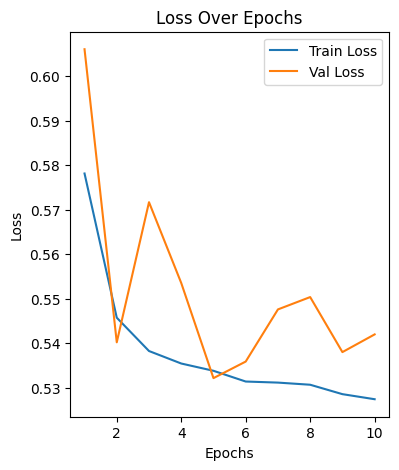

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming history is from model.fit()
def plot_training(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(14, 5))

    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    # F1-score (if stored during training)
    if 'val_f1' in history.history:
        plt.subplot(1, 3, 2)
        plt.plot(epochs, history.history['val_f1'], label='Val F1')
        plt.xlabel('Epochs')
        plt.ylabel('F1-score')
        plt.title('Validation F1 Over Epochs')
        plt.legend()

    # AUC
    if 'val_auc' in history.history:
        plt.subplot(1, 3, 3)
        plt.plot(epochs, history.history['val_auc'], label='Val AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.title('Validation AUC Over Epochs')
        plt.legend()

    plt.show()

# Call after training
plot_training(history)


In [33]:
# Check shape of y_train
print("y_train shape:", Y_train.shape)

# Verify it matches your label count
num_samples, num_classes = Y_train.shape
print(f"Number of samples: {num_samples}")
print(f"Number of classes: {num_classes}")

# Make sure it matches LABEL_COLUMNS length
if num_classes != len(LABEL_COLUMNS):
    print("⚠️ Warning: Number of classes in y_train doesn't match LABEL_COLUMNS length!")
else:
    print("✅ y_train shape matches LABEL_COLUMNS length.")

y_train shape: (9039, 9)
Number of samples: 9039
Number of classes: 9
✅ y_train shape matches LABEL_COLUMNS length.


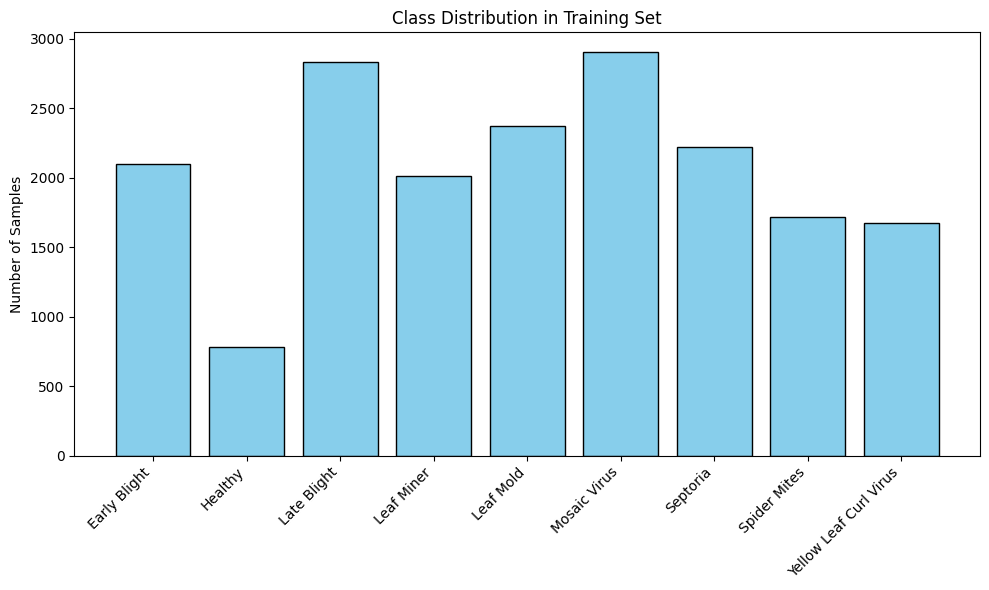

📊 Label Counts: {'Early Blight': 2097.0, 'Healthy': 783.0, 'Late Blight': 2835.0, 'Leaf Miner': 2012.0, 'Leaf Mold': 2373.0, 'Mosaic Virus': 2902.0, 'Septoria': 2218.0, 'Spider Mites': 1716.0, 'Yellow Leaf Curl Virus': 1672.0}
⚠️ Most underrepresented classes (783.0 samples): ['Healthy']


In [36]:
# Count occurrences for each label
label_counts = np.sum(Y_train, axis=0)

# Plot class distribution
plt.figure(figsize=(10, 6))
plt.bar(LABEL_COLUMNS, label_counts, color='skyblue', edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.tight_layout()
plt.show()

# Find the most underrepresented classes
min_count = np.min(label_counts)
underrepresented = [LABEL_COLUMNS[i] for i, count in enumerate(label_counts) if count == min_count]

print("📊 Label Counts:", dict(zip(LABEL_COLUMNS, label_counts)))
print(f"⚠️ Most underrepresented classes ({min_count} samples): {underrepresented}")


## Oversampling Rare Cases

In [38]:
import numpy as np

healthy_indices = np.where(Y_train[:, LABEL_COLUMNS.index('Healthy')] == 1)[0]
healthy_images = X_train[healthy_indices]
healthy_labels = Y_train[healthy_indices]

# Duplicate to balance
dup_factor = int(max(np.sum(Y_train, axis=0)) / len(healthy_indices))
X_train_balanced = np.concatenate([X_train] + [healthy_images] * dup_factor)
y_train_balanced = np.concatenate([Y_train] + [healthy_labels] * dup_factor)

In [39]:
dup_factor

3

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Flatten for class_weight computation (works better for single-label but can be adapted)
import numpy as np
class_weights = {}
total_samples = Y_train.shape[0]
for i, label in enumerate(LABEL_COLUMNS):
    count = np.sum(Y_train[:, i])
    class_weights[i] = total_samples / (len(LABEL_COLUMNS) * count)

print(class_weights)

model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=30,
    batch_size=32,
    class_weight=class_weights
)
